In [1]:
import time
import string
import pandas as pd
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('job_details_processed.csv')

In [3]:
# Create tfidf matrix
stop = stopwords.words('english')
custom_stop = ['job', 'summary', 'work', 'working', 'type','time', 'team', 'full', 'singapore', 'location', 'requirements', '’', 'about', 'us',
               'experience', 'skills', 'world', 'build', "'s"]
stop.extend(custom_stop)
vectorizer = TfidfVectorizer(max_df=0.7, max_features=2500,
                             min_df=3, stop_words=stop,
                             use_idf=True)
X = vectorizer.fit_transform(df['tokens'])
X.shape

(924, 2500)

In [4]:
# Use SVD to reduce dimensions
svd = TruncatedSVD(300)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)

X.shape

(924, 2500)

In [5]:
# Check how much variance is explained
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 71%


In [6]:
# Now the actual clustering
# Set random state here, then every time & every run will use the same data, get the same result
# Set the num of clusters
num = 5
km = KMeans(n_clusters=num, init='k-means++', max_iter=1000, n_init=1, random_state=4321) 

%time km.fit(X_lsa)

Wall time: 166 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=5, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=4321, tol=0.0001, verbose=0)

In [17]:
# Add the label of clusters to data frame, save it to csv
df["cluster"] = km.labels_
df.to_csv('job_details_with_cluster.csv', index=False)
df.head()

,job_title,job_desc,tokens,cluster,title_tokens
0,(Urgent!) IT Support,Permanent\nLogging and processing support call...,urgent support permanent logging processing su...,2,urgent support
1,.Net Developer,Job Summary\nAbout Us\nInfosys is a leading pr...,.net developer infosys leading provider next-g...,4,.net developer
2,.Net Software Engineers,Joining Accenture provides you with the opport...,.net software engineers joining accenture prov...,3,.net software engineers
3,2nd / 3rd Line Technical Support Engineer,Permanent\nRoles & Responsibilities\nOn a day-...,line technical support engineer permanent role...,2,line technical support engineer
4,AMOS Support Specialist,Roles & Responsibilities\nLufthansa Systems is...,amos support specialist roles responsibilities...,2,amos support specialist


In [41]:
record_count=[]
cluster_name=['General IT','Business Development','Support Engineer','Business Analyst','Software Engineer']
for i in range(0,5):
    record_count.append(df['cluster'][df['cluster'] == i].count())
cluster_df=pd.DataFrame(
    {'Cluster Name': cluster_name,
     'Number of Postings': record_count
    })
cluster_df

,Cluster Name,Number of Postings
0,General IT,157
1,Business Development,159
2,Support Engineer,209
3,Business Analyst,234
4,Software Engineer,165


In [8]:
punctuation = string.punctuation
punctuation = punctuation + '-' + '–'

conditions = [
#     lambda t: len(t) < 3,
    lambda t: t in punctuation,
    lambda t: any(c.isdigit() for c in t),
]

stop = stopwords.words('english')
stop.extend(['singapore'])

# Pre_process text, remove words is punctuation or digit, remove stop words
def pre_process(desc, conditions, stop):
    tokens_nop = [ t for t in word_tokenize(desc) if not any(f(t) for f in conditions)]
    tokens_lower = [ t.lower() for t in tokens_nop ]
    tokens_nostop = [ t for t in tokens_lower if t not in stop ]
    return tokens_nostop

In [9]:
# Pre_process job_title, add new column title_tokens
df["title_tokens"] = df.job_title.apply(lambda x: pre_process(x, conditions, stop))
# df[df.cluster==2][["job_title", "title_tokens"]]

# Join the job_title_tokens, groupby by their label of clusters
df.title_tokens = df.title_tokens.str.join(" ")
job_clusters = df.groupby("cluster").apply(lambda g:" ".join(g.title_tokens)).tolist()

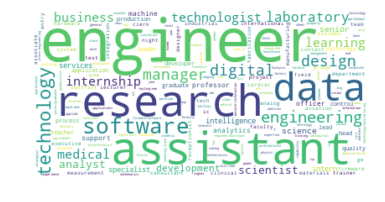

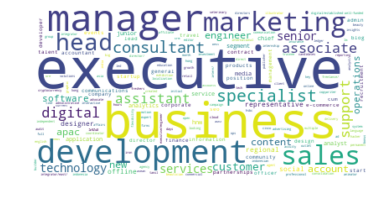

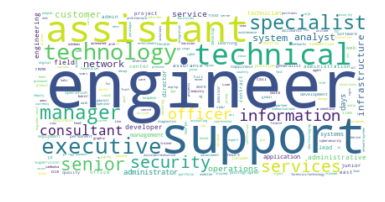

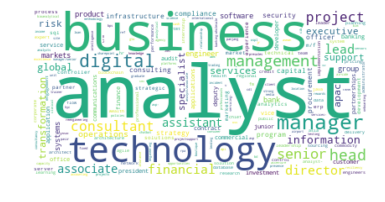

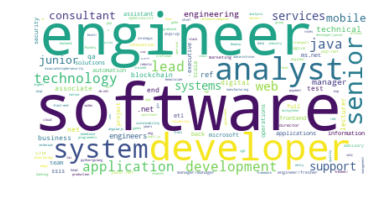

In [10]:
# For each cluster, generate a wordcloud for the title_tokens
for values in job_clusters:
    fd = nltk.FreqDist(values.split())

    wordcloud = WordCloud(background_color="white").generate_from_frequencies(fd)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
# need to name the labels 